In [30]:
import pandas as pd
import numpy as np
import os
from dotenv import dotenv_values, find_dotenv
import datetime as dt
import preparecorrelations as pc

In [31]:
import importlib
importlib.reload(pc)

<module 'preparecorrelations' from 'c:\\Users\\fuem\\Documents\\myproject\\yetanotherfolder\\preparecorrelations.py'>

In [3]:
# this looks for your configuration file and then reads it as a dictionary
config = dotenv_values(find_dotenv())

# set path using the dictionary key for which one you want
correlationpath = os.path.abspath(config["CORRELATIONDATA"]) + '\\'
cleandatapath = os.path.abspath(config["CLEANDATA"]) + '\\'

In [5]:
xlsx = pd.ExcelFile(correlationpath + "gdp_consumption_haver_final.xlsx")

rgdp = pd.read_excel(xlsx, 'Real GDP')
rc = pd.read_excel(xlsx, 'Real C')

oecdemployment = pc.get_from_oecd("STLABOUR/AUS+AUT+BEL+CAN+DNK+FIN+FRA+DEU+GRC+IRL+ITA+JPN+NOR+NLD+NZL+PRT+ESP+SWE+CHE+GBR+USA.LREM64TT.STSA.Q/OECD")
oecdunemployment = pc.get_from_oecd("STLABOUR/AUS+AUT+BEL+CAN+DNK+FIN+FRA+DEU+GRC+IRL+ITA+JPN+NOR+NLD+NZL+PRT+ESP+SWE+CHE+GBR+USA.LRUN64TT.STSA.Q/OECD")

imfipi = pc.get_from_imf('CompactData/IFS/Q..AIP_SA_IX')


In [13]:
# the developed countries included in the gdp/consumption series
oecd_countries = ["Australia", "Austria", "Belgium", "Canada", "Denmark", "Finland", "France", "Germany", "Greece", "Iceland", "Ireland", 
                  "Italy", "Japan", "Luxembourg", "Netherlands", "Norway", "Portugal", "Spain", "Sweden", "Switzerland", 
                  "Turkey", "U.K.", "U.S."] 

# the EMEs included in the gdp/consumption series
MSCI_EM_countries = ["Brazil", "Chile", "China", "Colombia", "Czech Republic", "Egypt", "Greece", "Hungary", "India", 
                     "Indonesia", "South Korea", "Kuwait", "Malaysia", "Mexico", "Peru", "Philippines", "Poland", "Qatar", 
                     "Saudi Arabia", "South Africa", "Taiwan", "Thailand", "Turkey", "United Arab Emirates"]

# some countries we wanted to remove from the GDP/consumption series for not having enough data (decided previously)
to_remove = ['Egypt', 'Saudi Arabia', 'Malaysia', 'Colombia', 'Qatar', 'Kuwait', 'China']

# the countries that will be used for the gdp/consumption stuff
original_countries = list(set(oecd_countries + MSCI_EM_countries) - set(to_remove))

# the countries that will be used for the employment/unemployment/industrial production stuff (from frankel and rose paper)
frankelrosecountries = ['AUS', 'AUT', 'BEL', 'CAN', 'DNK', 'FIN', 'FRA', 'DEU', 'GRC', 'IRL', 'ITA', 'JPN', 'NOR', 'NLD', 'NZL', 'PRT', 'ESP', 'SWE', 'CHE', 'GBR', 'USA']

# Haver data: real GDP

In [15]:
# seasonally adjusting the gdp series (imf/oecd data are already seasonally adjusted)
rgdp_sa = pc.SeasonalAdjustment(pc.fixCols(rgdp, original_countries))

c:\Users\fuem\.conda\envs\myenv\Lib\site-packages\statsmodels\tsa\x13.py:189: X13Warning: NOTE: Unable to test LS2020.2 due to regression matrix singularity.
       The effect of this outlier is already accounted for by other regressors 
       (usually user-specified or previously identified outliers).

 NOTE: Unable to test LS2020.3 due to regression matrix singularity.
       The effect of this outlier is already accounted for by other regressors 
       (usually user-specified or previously identified outliers).

          so the standard errors and the correlation matrix of the ARMA
          parameters will not be printed out.


 NOTE: Unable to test LS2008.4 due to regression matrix singularity.
       The effect of this outlier is already accounted for by other regressors 
       (usually user-specified or previously identified outliers).

 NOTE: Unable to test LS2020.2 due to regression matrix singularity.
       The effect of this outlier is already accounted for by other reg

In [17]:
# show the detrended data

rgdp_detrend = pc.Prepare_Correlations(rgdp_sa, detrending="HP Filter", countries=list(rgdp_sa.columns)).detrend(start_date="1998-01-01", end_date="2021-12-31")

rgdp_detrend.data.tail()

,AUS,AUT,BEL,CAN,DNK,FIN,FRA,DEU,GRC,ISL,...,IDN,KOR,MEX,PER,PHL,POL,ZAF,TWN,THA,TUR
date,,,,,,,,,,,,,,,,,,,,,
2020-10-01,-0.006839,-0.034697,-0.020587,-0.008219,-0.016501,-0.007959,-0.014218,-0.008470,-0.038582,-0.035878,...,-0.016025,-0.014039,-0.009491,-0.001225,-0.041663,-0.026234,-0.005990,0.005214,-0.018284,0.008710
2021-01-01,0.007023,-0.040516,-0.010225,0.002295,-0.018020,-0.014397,-0.013196,-0.023081,0.003967,-0.024683,...,-0.009807,-0.001409,-0.002360,0.021121,-0.031369,-0.019726,0.005607,0.029754,-0.016387,0.022995
2021-04-01,0.009913,-0.000377,0.004919,-0.007714,-0.002474,0.001154,-0.002404,-0.001939,0.012766,-0.000505,...,-0.012693,0.001934,0.010403,0.024913,-0.036140,-0.008252,0.019332,0.011702,-0.015773,-0.013848
2021-07-01,-0.012174,0.032541,0.023173,0.003378,0.006495,0.010015,0.027470,0.011868,0.029161,-0.000728,...,-0.023498,0.000836,0.004429,0.060348,-0.010720,0.007099,0.003567,0.007841,-0.021880,0.035527
2021-10-01,0.018754,0.019176,0.026304,0.017298,0.031741,0.015031,0.034792,0.009451,0.033290,-0.003675,...,0.007304,0.006990,0.010652,0.015421,0.014687,0.017687,0.016061,0.009898,-0.000818,0.051017


In [18]:
# show the correlation matrix

rgdpcorrelations = rgdp_detrend.get_correlationmatrix()

rgdpcorrelations

,USA,MEX,BEL,CAN,GBR,FRA,DNK,HUN,AUT,ZAF,...,TUR,LUX,THA,ISL,KOR,BRA,TWN,GRC,IRL,IDN
USA,1.000000,0.918096,0.907854,0.902947,0.888706,0.857161,0.848856,0.847672,0.842206,0.839220,...,0.682134,0.672836,0.627790,0.607812,0.603793,0.577605,0.540587,0.482172,0.473307,0.354208
MEX,0.918096,1.000000,0.911767,0.917000,0.905838,0.883857,0.829223,0.857352,0.867716,0.904258,...,0.666265,0.656257,0.647998,0.640127,0.594537,0.598535,0.433907,0.489255,0.437614,0.456655
BEL,0.907854,0.911767,1.000000,0.890056,0.938824,0.953072,0.806018,0.842316,0.917148,0.892798,...,0.609940,0.687071,0.620712,0.563099,0.659848,0.634180,0.444030,0.574462,0.453749,0.475976
CAN,0.902947,0.917000,0.890056,1.000000,0.876441,0.895835,0.781543,0.859490,0.868690,0.889647,...,0.612896,0.600225,0.610395,0.575220,0.627902,0.699747,0.417210,0.446685,0.308742,0.487912
GBR,0.888706,0.905838,0.938824,0.876441,1.000000,0.931814,0.771252,0.894971,0.889862,0.925039,...,0.603254,0.617159,0.634845,0.589733,0.522185,0.557895,0.312487,0.624738,0.403150,0.479769
FRA,0.857161,0.883857,0.953072,0.895835,0.931814,1.000000,0.771765,0.822033,0.914174,0.885474,...,0.585344,0.627232,0.594056,0.546500,0.558974,0.640300,0.333629,0.526300,0.368111,0.440882
DNK,0.848856,0.829223,0.806018,0.781543,0.771252,0.771765,1.000000,0.777366,0.829404,0.734807,...,0.634963,0.677362,0.493647,0.685422,0.619305,0.425693,0.511811,0.392924,0.499816,0.317108
HUN,0.847672,0.857352,0.842316,0.859490,0.894971,0.822033,0.777366,1.000000,0.836240,0.877889,...,0.626699,0.528695,0.582281,0.624920,0.454164,0.569603,0.324456,0.606855,0.453428,0.509491
AUT,0.842206,0.867716,0.917148,0.868690,0.889862,0.914174,0.829404,0.836240,1.000000,0.844594,...,0.532475,0.632177,0.599263,0.671554,0.610324,0.570082,0.329595,0.503546,0.367606,0.470159
ZAF,0.839220,0.904258,0.892798,0.889647,0.925039,0.885474,0.734807,0.877889,0.844594,1.000000,...,0.617878,0.592791,0.592087,0.607104,0.476668,0.659437,0.289539,0.583527,0.365208,0.553559


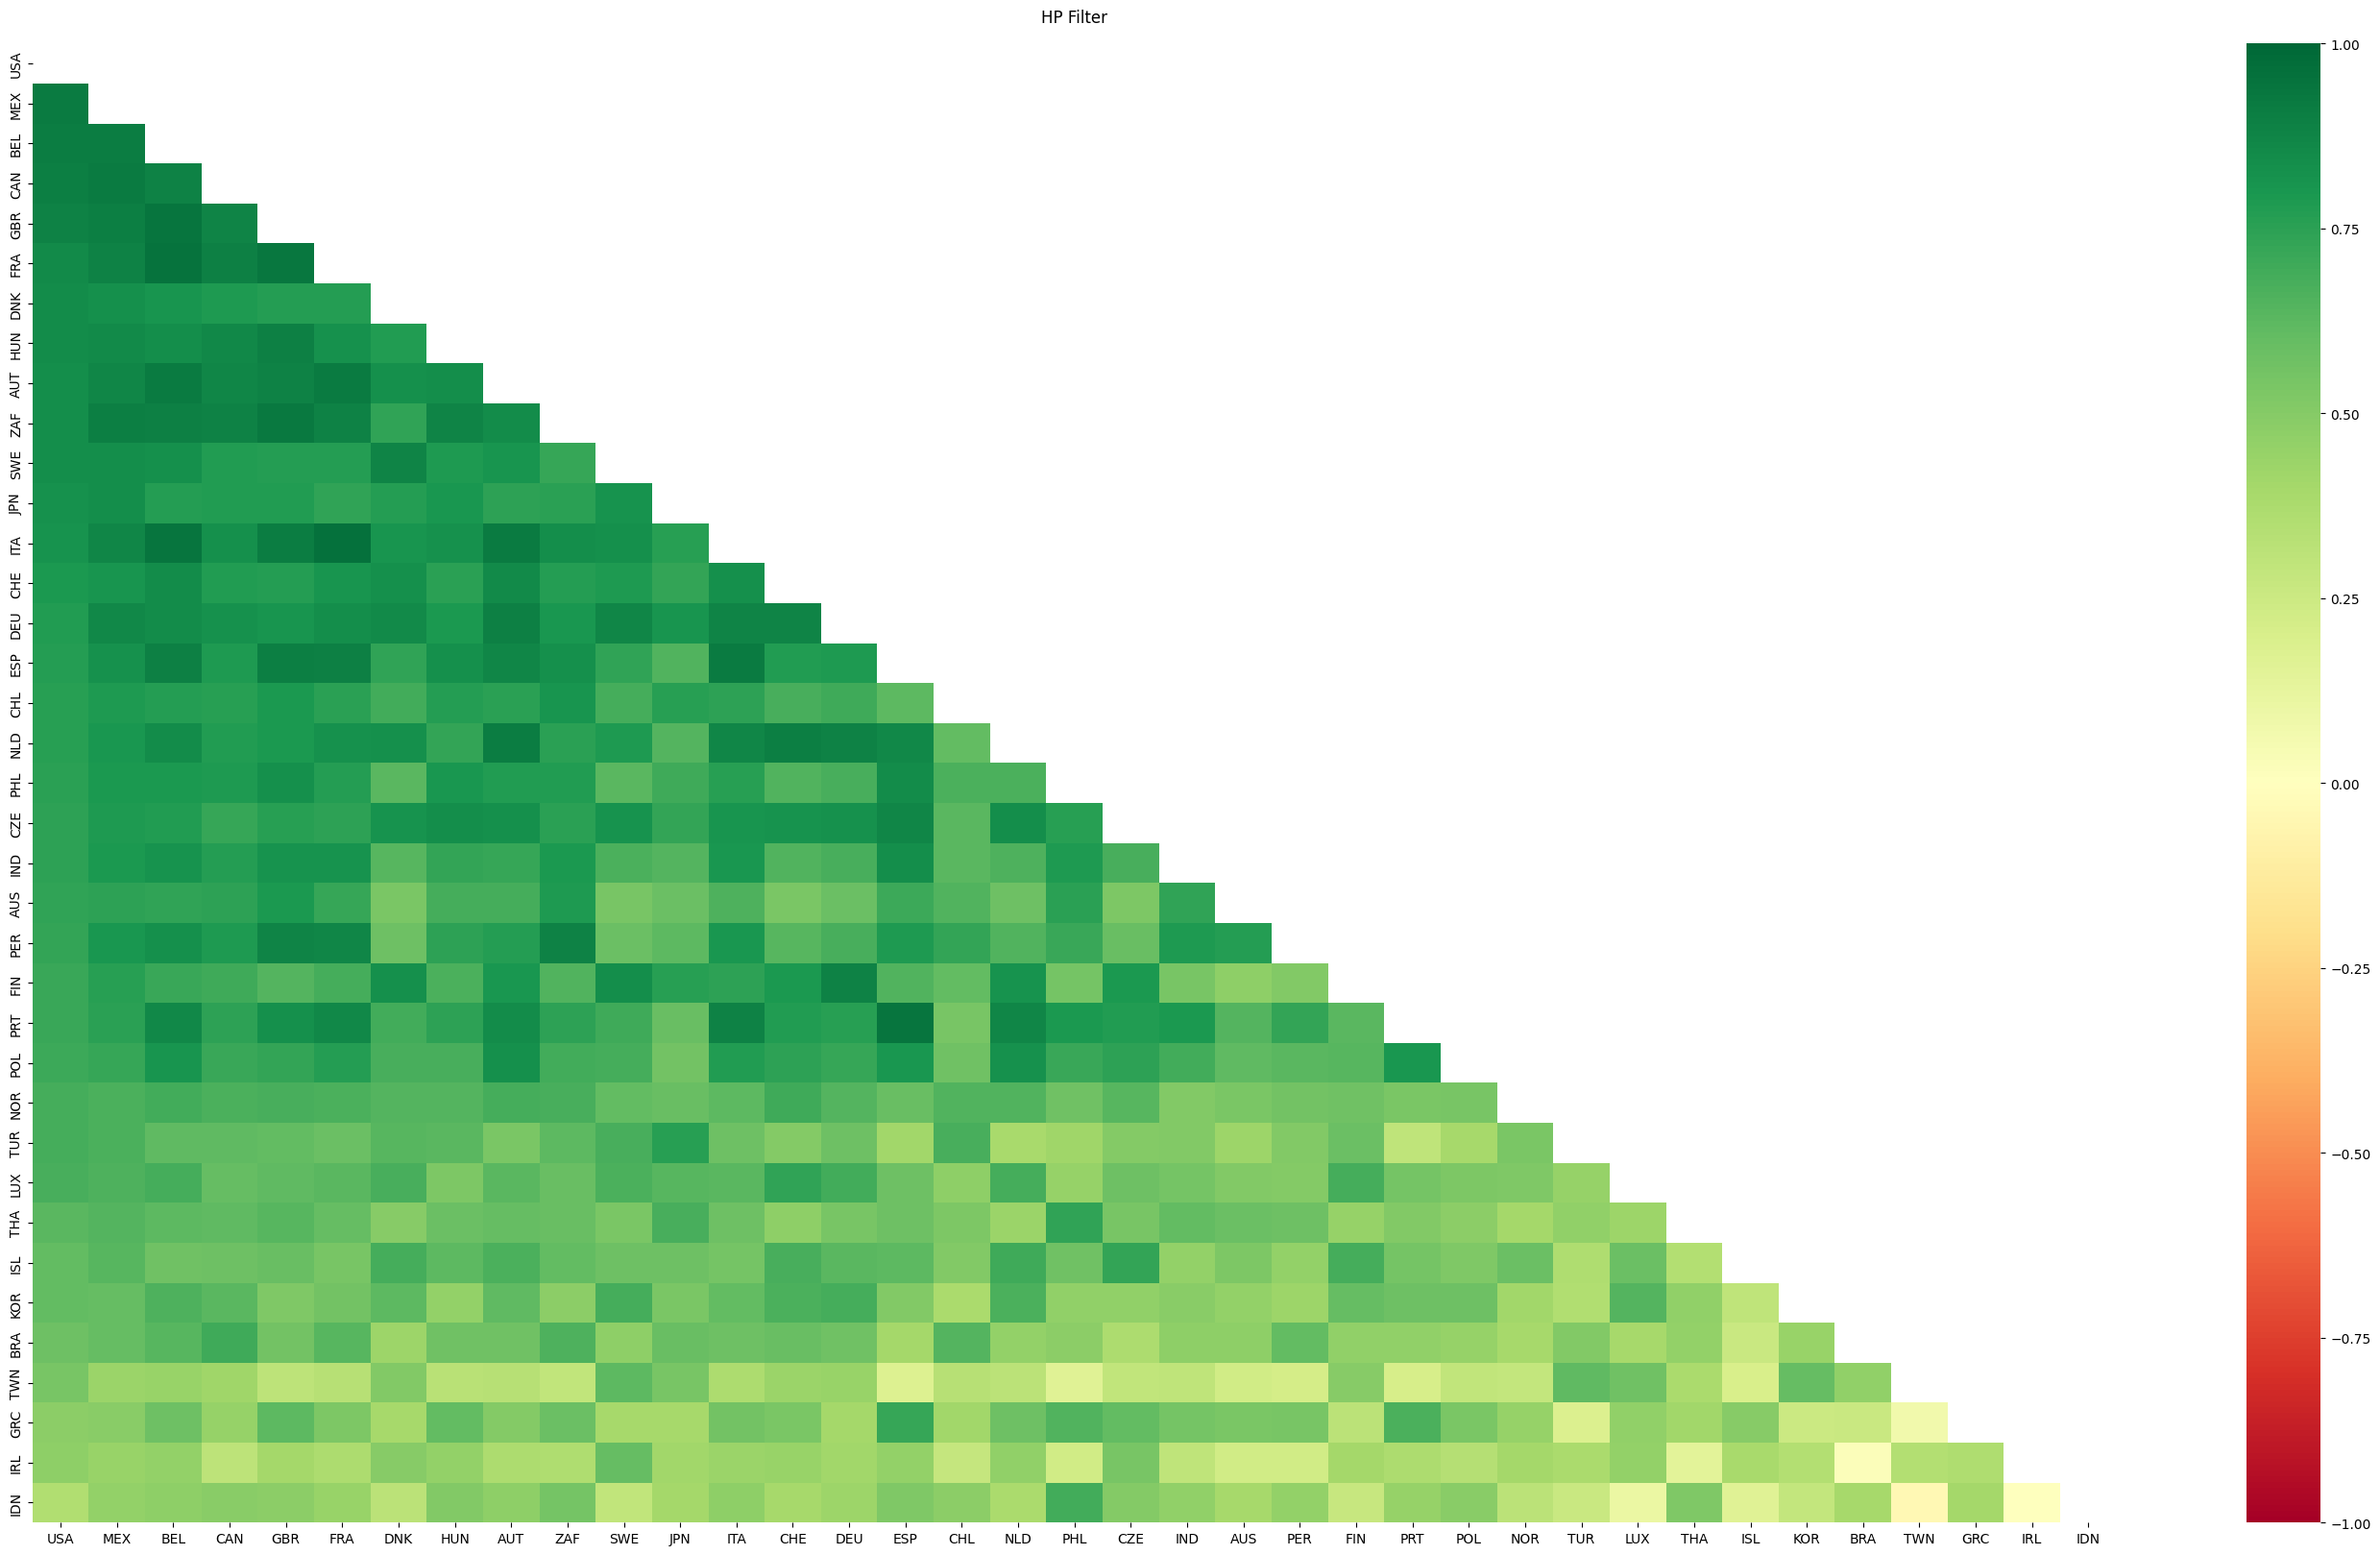

In [19]:

# show the heatmap visualisation

rgdpheatmap = rgdp_detrend.get_heatmap()

In [20]:
# show the reshaped version

rgdpreshaped = rgdp_detrend.get_organized()

rgdpreshaped.tail()

,iso3_firstcountry,iso3_secondcountry,correlation
1256,TWN,IRL,0.350499
1257,TWN,IDN,-0.045611
1293,GRC,IRL,0.366505
1294,GRC,IDN,0.403062
1331,IRL,IDN,0.006740


# OECD data: employment rate

In [57]:
# show the detrended data

oecdemploymentdetrend = pc.Prepare_Correlations(oecdemployment, detrending="first difference", countries=frankelrosecountries).detrend(start_date="1998-01-01", end_date="2021-12-31")

oecdemploymentdetrend.data.tail()

,AUS,AUT,BEL,CAN,CHE,DEU,DNK,ESP,FIN,FRA,...,GRC,IRL,ITA,JPN,NLD,NOR,NZL,PRT,SWE,USA
date,,,,,,,,,,,,,,,,,,,,,
2020-10-01,0.020318,-0.002188,-0.007787,0.024750,0.006280,0.007526,0.006592,0.006613,0.004877,0.005314,...,-0.031343,0.004923,0.005239,0.004007,0.004723,0.002089,0.005907,0.011983,0.002708,0.022168
2021-01-01,0.010702,-0.005474,-0.005432,-0.000923,-0.015577,0.000594,-0.004561,0.001981,0.002932,0.004690,...,-0.000928,-0.005137,-0.011190,0.003236,0.002325,0.005203,0.007751,-0.004662,-0.002493,0.007604
2021-04-01,0.011130,0.008935,0.022043,0.006443,-0.007100,0.008386,0.021949,0.021209,0.016411,0.008742,...,0.063538,0.045351,0.022103,0.000797,0.005187,0.015143,0.009879,0.020921,0.011478,0.007637
2021-07-01,-0.004767,0.015636,0.018051,0.018633,0.012525,0.014019,-0.001248,0.013868,-0.000173,0.006546,...,0.027920,0.034211,0.015370,0.002731,0.007259,0.012238,0.015087,0.011355,0.003977,0.012247
2021-10-01,0.006611,0.004499,-0.003138,0.014749,0.008872,0.005258,0.013455,0.007841,0.010189,0.002488,...,0.007642,0.013380,0.009849,-0.000868,0.005354,0.006282,0.002519,0.001166,0.006201,0.011098


In [22]:
# show the correlation matrix

oecdemploymentmatrix = oecdemploymentdetrend.get_correlationmatrix()

oecdemploymentmatrix

,USA,CAN,AUS,IRL,ESP,AUT,GRC,ITA,FRA,FIN,...,JPN,PRT,SWE,NOR,BEL,DNK,NLD,GBR,DEU,NZL
USA,1.000000,0.952678,0.865939,0.761113,0.698940,0.647747,0.644433,0.590222,0.522463,0.509904,...,0.492607,0.474288,0.471264,0.376168,0.276563,0.251296,0.231825,0.202697,0.197400,0.153473
CAN,0.952678,1.000000,0.837190,0.713424,0.661237,0.672434,0.690924,0.569392,0.466940,0.484861,...,0.380602,0.426351,0.412299,0.311956,0.272849,0.195947,0.202013,0.081529,0.254700,0.095444
AUS,0.865939,0.837190,1.000000,0.643045,0.660141,0.577390,0.557244,0.513649,0.528755,0.517981,...,0.440501,0.444762,0.452895,0.354207,0.276312,0.196838,0.199826,0.152152,0.209613,0.147777
IRL,0.761113,0.713424,0.643045,1.000000,0.819638,0.585586,0.650525,0.680256,0.628388,0.631562,...,0.507957,0.629589,0.643604,0.508235,0.382390,0.448651,0.176374,0.392845,0.385144,0.382425
ESP,0.698940,0.661237,0.660141,0.819638,1.000000,0.513562,0.693735,0.739635,0.637405,0.606200,...,0.469300,0.720150,0.584604,0.371086,0.344418,0.478690,0.093941,0.350148,0.379150,0.351729
AUT,0.647747,0.672434,0.577390,0.585586,0.513562,1.000000,0.584829,0.312842,0.440422,0.466789,...,0.345400,0.313493,0.412917,0.389127,0.350312,0.208723,0.179251,0.103127,0.315359,0.042713
GRC,0.644433,0.690924,0.557244,0.650525,0.693735,0.584829,1.000000,0.589863,0.391913,0.375160,...,0.256153,0.455686,0.279358,0.287873,0.344705,0.333184,0.190426,0.104934,0.148435,0.082469
ITA,0.590222,0.569392,0.513649,0.680256,0.739635,0.312842,0.589863,1.000000,0.572616,0.480421,...,0.265204,0.621077,0.542798,0.396862,0.288034,0.490624,0.283099,0.336270,0.382967,0.314531
FRA,0.522463,0.466940,0.528755,0.628388,0.637405,0.440422,0.391913,0.572616,1.000000,0.754840,...,0.470553,0.736590,0.630568,0.446832,0.354284,0.493894,-0.019009,0.384354,0.486553,0.293736
FIN,0.509904,0.484861,0.517981,0.631562,0.606200,0.466789,0.375160,0.480421,0.754840,1.000000,...,0.368729,0.476649,0.674878,0.484378,0.261265,0.473047,0.166854,0.336527,0.449516,0.164825


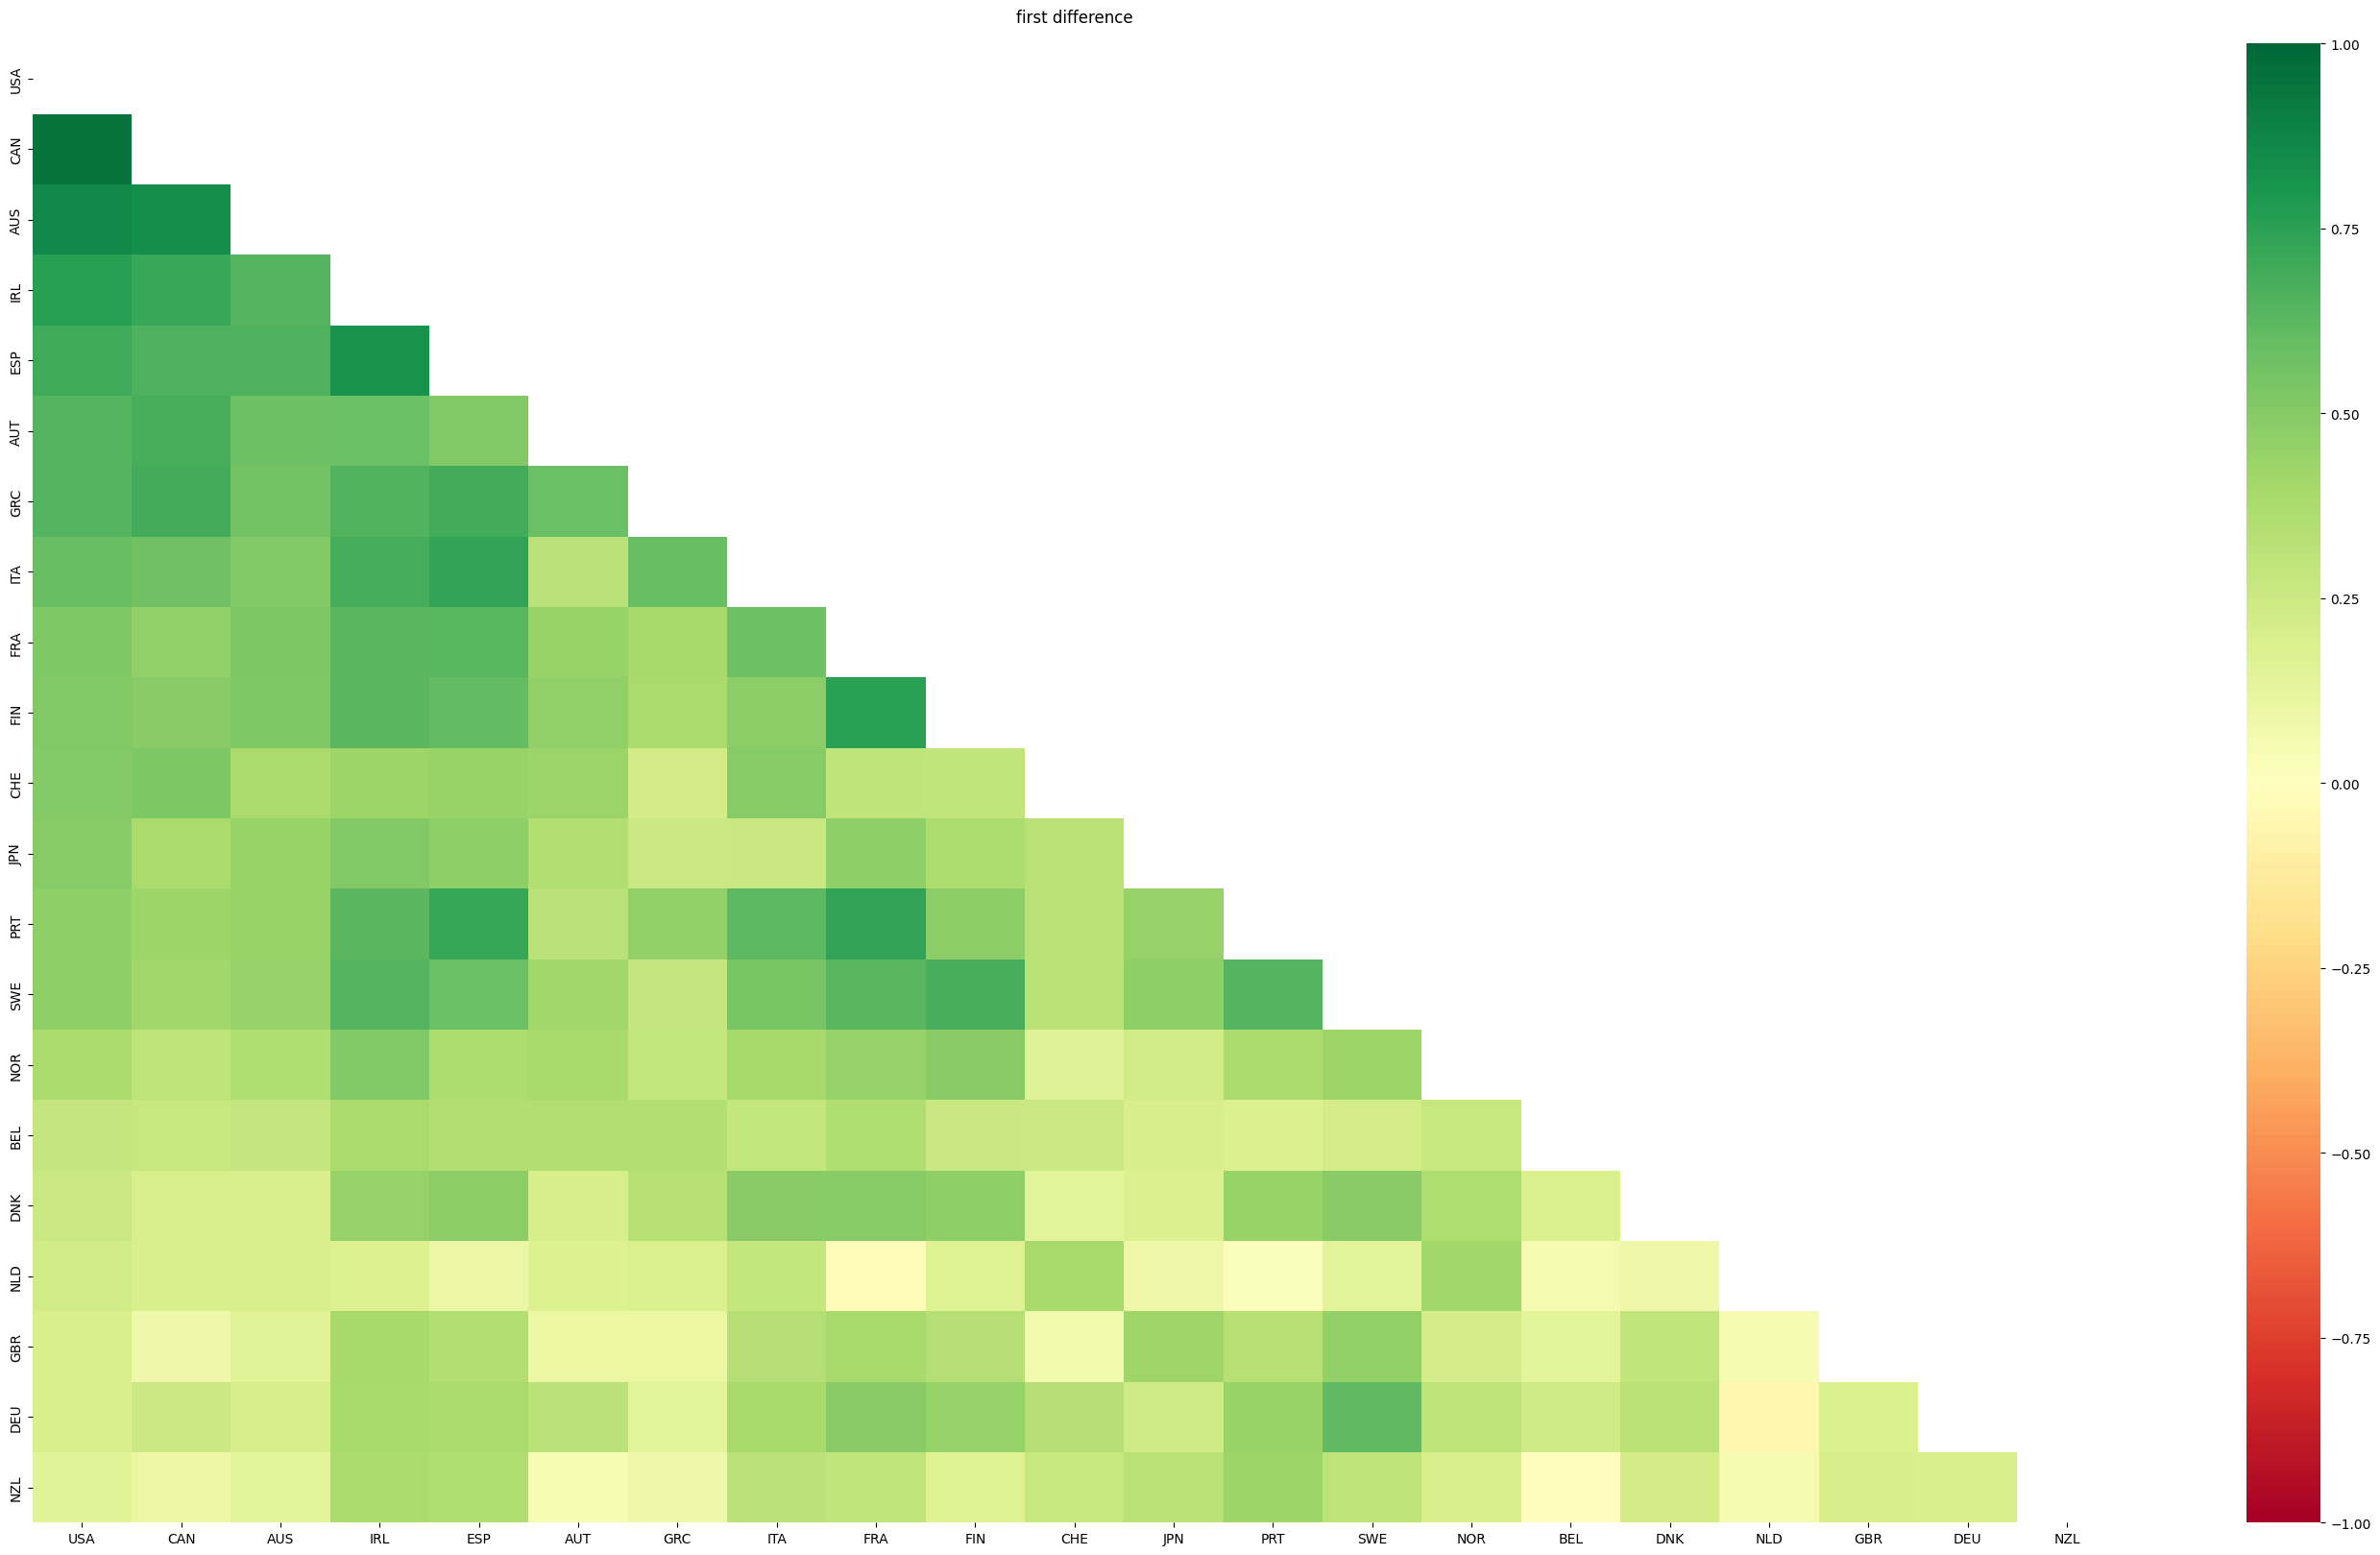

In [23]:
# show the heatmap visualisation

oecdemploymentheatmap = oecdemploymentdetrend.get_heatmap()

In [49]:
# show the reshaped version: 

oecdemploymentreshaped = oecdemploymentdetrend.get_organized()

oecdemploymentreshaped.tail()


,iso3_firstcountry,iso3_secondcountry,correlation
376,NLD,DEU,-0.067122
377,NLD,NZL,0.060215
397,GBR,DEU,0.188856
398,GBR,NZL,0.209660
419,DEU,NZL,0.200005


# IMF data: industrial production index

In [46]:
imfipidetrend = pc.Prepare_Correlations(imfipi, detrending="linear detrending", countries=frankelrosecountries).detrend(start_date="2000-01-01", end_date="2021-12-31")

imfipidetrend.data.tail()

,AUT,AUS,BEL,CAN,CHE,DEU,DNK,ESP,FIN,FRA,...,GRC,IRL,ITA,JPN,NLD,NOR,NZL,PRT,SWE,USA
date,,,,,,,,,,,,,,,,,,,,,
2020-10-01,-0.025409,-0.004551,-0.024625,0.012318,-0.020333,-0.053564,0.018416,0.062526,-0.000136,0.009615,...,0.084492,0.238299,0.038333,-0.045025,-0.040450,0.038247,0.009412,0.059891,0.039099,-0.037263
2021-01-01,-0.015818,-0.053862,0.013492,0.021887,0.017126,-0.059146,0.062995,0.070603,0.014578,0.010167,...,0.139382,0.307168,0.062543,-0.016733,-0.025389,0.072962,0.013371,0.053977,0.055399,-0.030721
2021-04-01,-0.005883,-0.057197,0.098616,0.015283,0.039161,-0.067846,0.059700,0.060519,0.019299,0.007665,...,0.161779,0.255422,0.071672,-0.015054,-0.011545,0.079603,0.033684,0.023516,0.063547,-0.016220
2021-07-01,0.012246,-0.062273,0.085135,0.028318,0.031478,-0.098038,0.108732,0.060141,0.038375,0.008892,...,0.180184,0.303085,0.085860,-0.033930,-0.004306,0.110702,-0.035773,0.023706,0.059056,-0.008840
2021-10-01,0.051735,-0.068893,0.058698,0.042329,0.025140,-0.075606,0.148337,0.094714,0.069005,0.010458,...,0.214566,0.278517,0.098044,-0.025227,-0.001597,0.084794,0.007659,0.055126,0.075011,0.001608


In [47]:
# show the correlation matrix

imfipimatrix = imfipidetrend.get_correlationmatrix()

imfipimatrix

,USA,JPN,DEU,FRA,AUT,ITA,SWE,ESP,NZL,PRT,...,FIN,AUS,DNK,NLD,BEL,CHE,GBR,GRC,IRL,NOR
USA,1.000000,0.841215,0.799439,0.768083,0.714980,0.596314,0.558480,0.531214,0.523404,0.462413,...,0.444380,0.438057,0.432231,0.426010,0.399130,0.361861,0.195465,0.145447,0.034092,-0.016829
JPN,0.841215,1.000000,0.801586,0.791771,0.792534,0.709933,0.718626,0.676468,0.687526,0.526182,...,0.670424,0.641060,0.434336,0.578133,0.587378,0.425711,0.264084,0.306117,0.072553,0.025367
DEU,0.799439,0.801586,1.000000,0.682123,0.789947,0.479366,0.448587,0.351775,0.387898,0.279313,...,0.448972,0.732564,0.090545,0.659523,0.549831,0.461807,-0.144580,-0.122272,-0.224028,-0.333578
FRA,0.768083,0.791771,0.682123,1.000000,0.780210,0.909149,0.809095,0.836748,0.689244,0.815201,...,0.614427,0.442721,0.675478,0.365975,0.473301,0.321851,0.523730,0.488898,0.322194,0.231623
AUT,0.714980,0.792534,0.789947,0.780210,1.000000,0.742915,0.787830,0.669366,0.552898,0.465292,...,0.802830,0.776198,0.417886,0.704200,0.806719,0.616783,0.237358,0.359276,0.000506,0.016041
ITA,0.596314,0.709933,0.479366,0.909149,0.742915,1.000000,0.897600,0.923013,0.672175,0.852652,...,0.728799,0.364078,0.783362,0.280573,0.535613,0.403078,0.702308,0.730869,0.486391,0.446874
SWE,0.558480,0.718626,0.448587,0.809095,0.787830,0.897600,1.000000,0.889111,0.662563,0.706480,...,0.877874,0.513136,0.761218,0.393149,0.651649,0.436841,0.627520,0.731261,0.365902,0.387430
ESP,0.531214,0.676468,0.351775,0.836748,0.669366,0.923013,0.889111,1.000000,0.772422,0.884549,...,0.748525,0.330745,0.815772,0.209771,0.455386,0.274030,0.802011,0.826203,0.561872,0.539221
NZL,0.523404,0.687526,0.387898,0.689244,0.552898,0.672175,0.662563,0.772422,1.000000,0.653816,...,0.549052,0.369952,0.514573,0.394509,0.383369,0.074858,0.546034,0.526155,0.315146,0.292941
PRT,0.462413,0.526182,0.279313,0.815201,0.465292,0.852652,0.706480,0.884549,0.653816,1.000000,...,0.458840,0.094201,0.788741,-0.028392,0.179223,0.076628,0.782761,0.702214,0.594617,0.550058


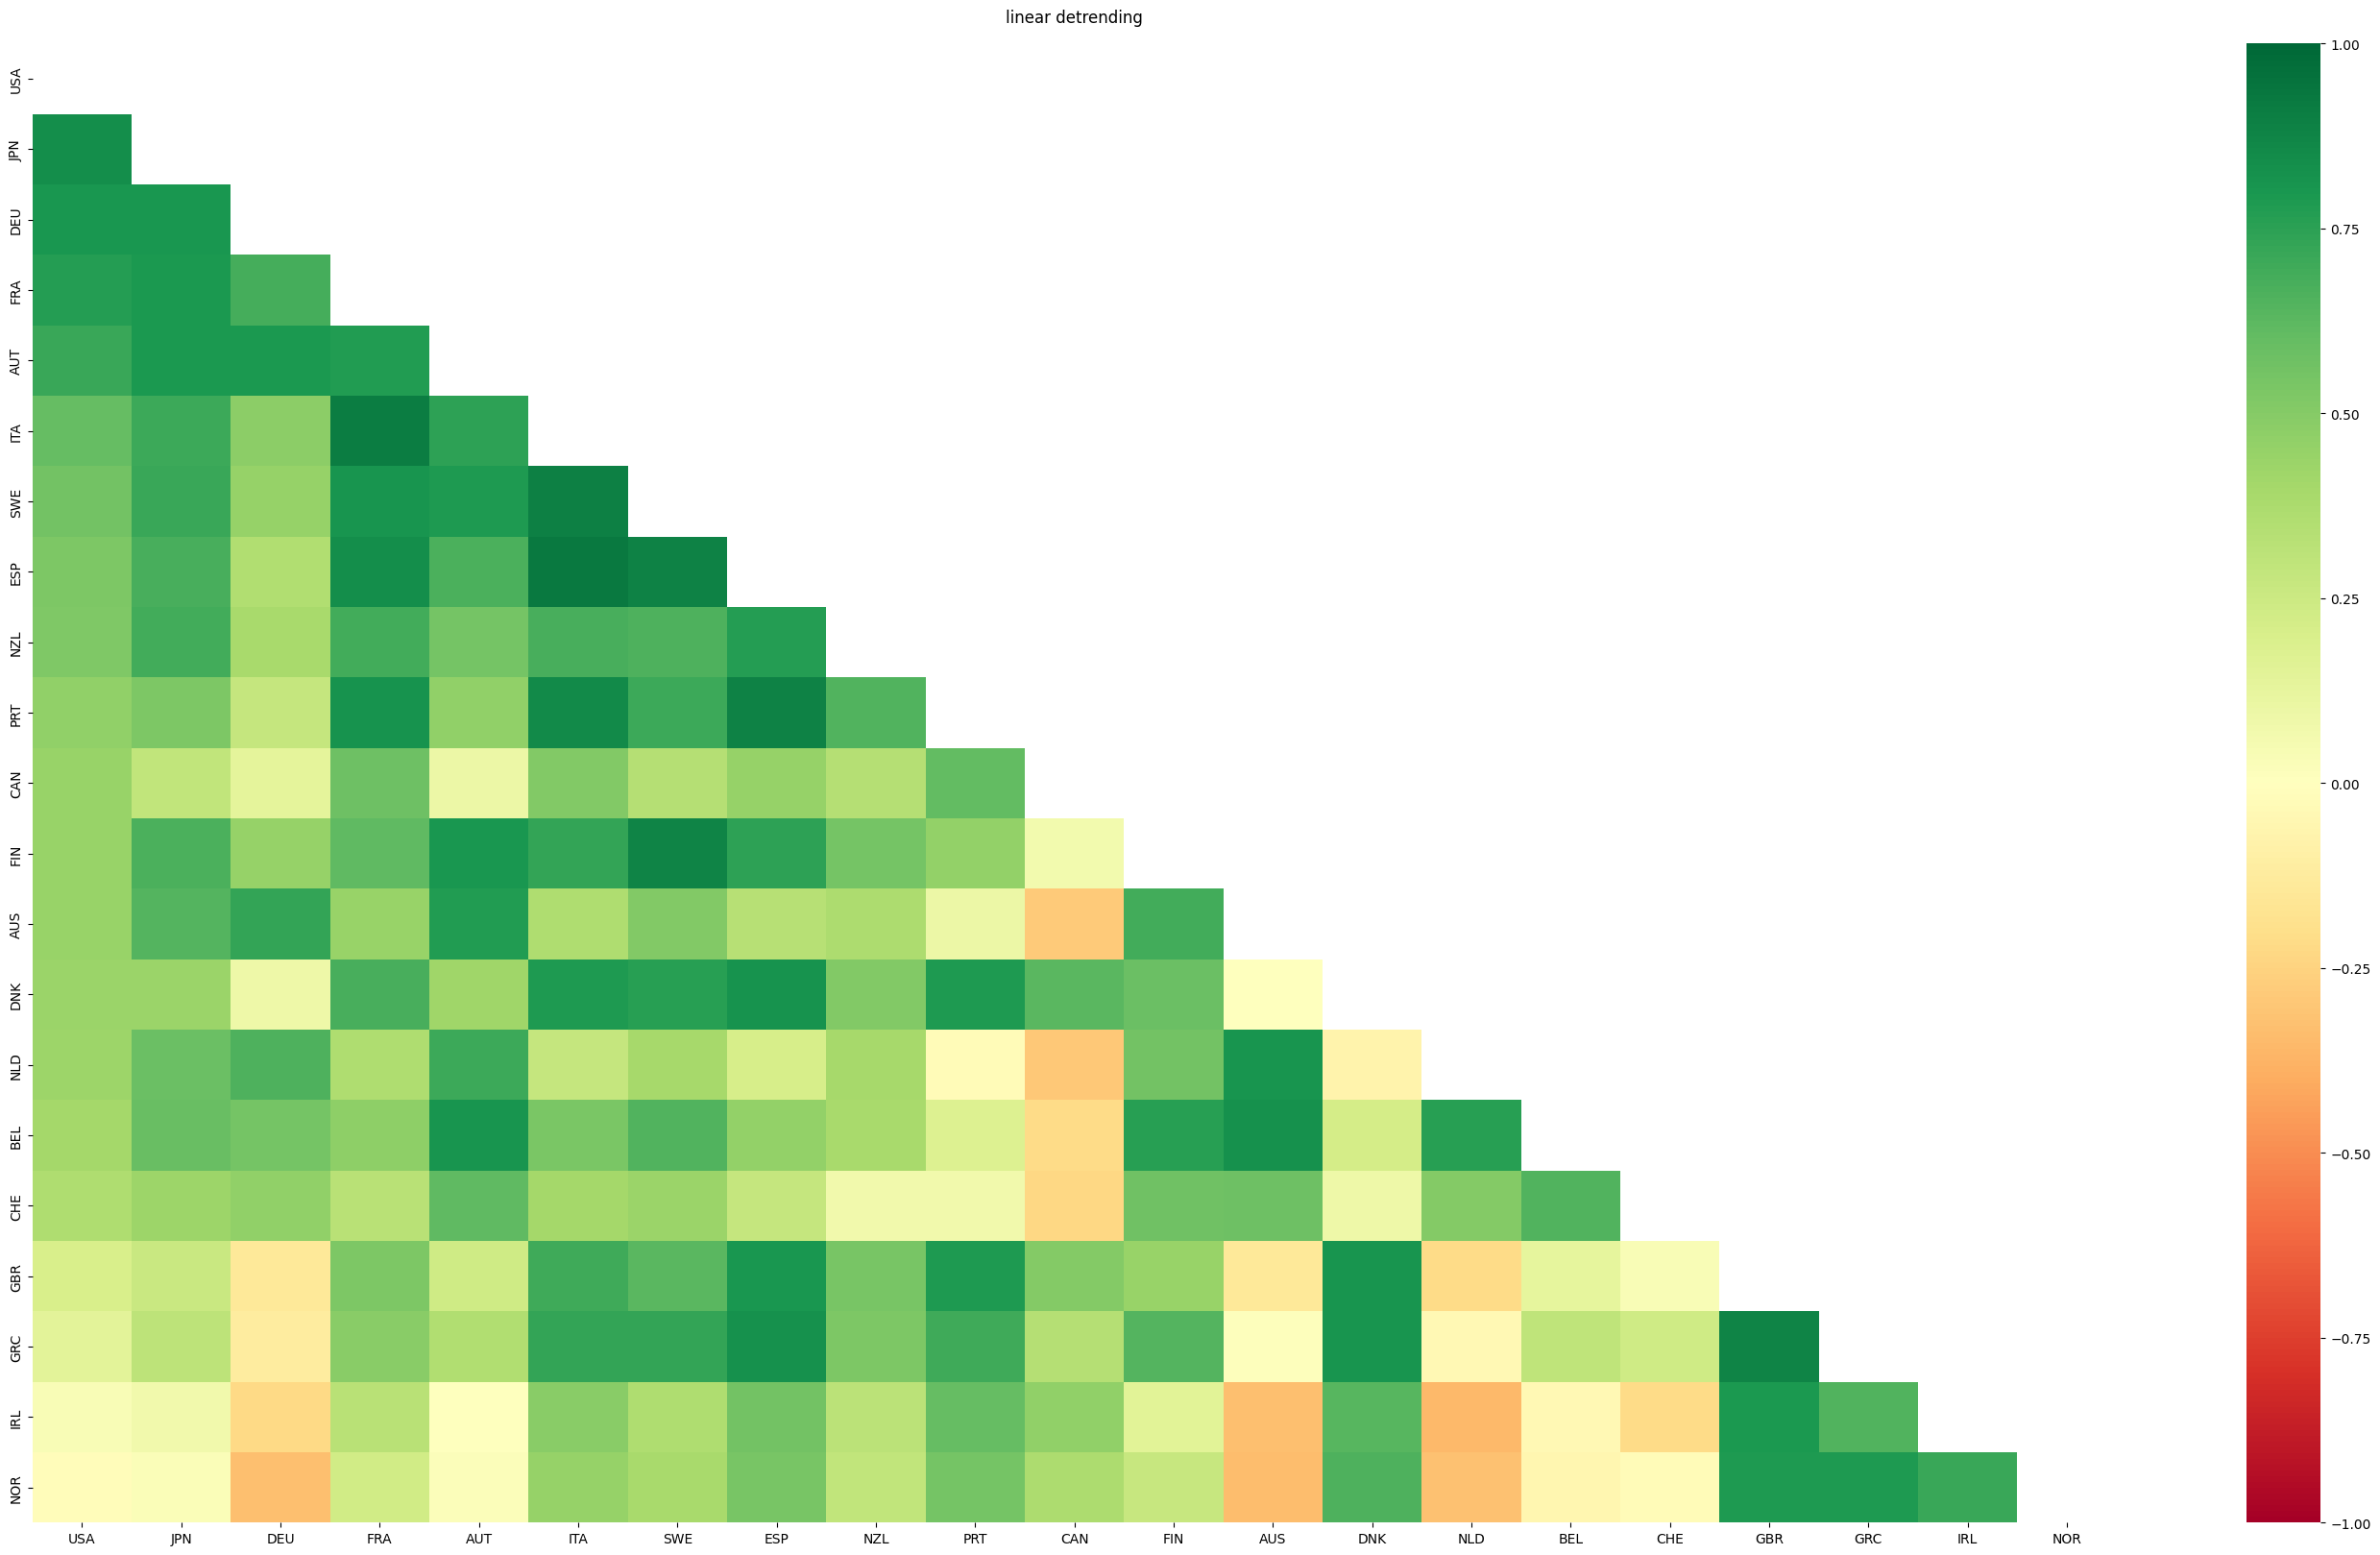

In [48]:
# show the heatmap visualisation

imfipiheatmap = imfipidetrend.get_heatmap()

In [50]:
# show the reshaped version: 

imfipireshaped = imfipidetrend.get_organized()

imfipireshaped.tail()


,iso3_firstcountry,iso3_secondcountry,correlation
376,GBR,IRL,0.792504
377,GBR,NOR,0.784399
397,GRC,IRL,0.654386
398,GRC,NOR,0.786516
419,IRL,NOR,0.718233
